In [8]:
import re
from graphviz import Digraph
import typing
import IPython
from __future__ import annotations

Грамматика


```
<выражение> ->
    <арифметическое выражение> <знак операции отношения> <арифметическое выражение>

<арифметическое выражение> ->
    [ <знак операции типа сложение> ] <терм> { <знак операции типа сложение> <терм> }

<терм> ->
    <множитель> [ <знак операции типа умножение> <терм> ]

<множитель> ->
    <первичное выражение> [ ^ <множитель> ]

<первичное выражение> ->
    <число> |
    <идентификатор> |
    ( <арифметическое выражение> )

<знак операции типа сложение> ->
    + | -

<знак операции типа умножение> ->
    * | / | %

<знак операции отношения> ->
    < | <= | = | >= | > | <>
```

```
<программа> ->
    <блок>

<блок> ->
    { <список операторов> }

<список  операторов> ->
    <оператор> <хвост>

<хвост> ->
    ; <оператор> <хвост>  |  \eps
```

In [9]:
class TreeNode:
	data = ""
	children: list[TreeNode]
	from_ = -1
	to_ = -1

	def __init__(self, data) -> None:
		self.data = data
		self.children = []
		pass

	def add_child(self, node: TreeNode):
		if not len(self.children):
			self.from_ = node.from_
		self.to_ = node.to_

		if node.data in ["<proxy>"]:
			for ch in node.children:
				self.add_child(ch)
			return

		self.children.append(node)

	def recurse(self, tree=None, parent=None, id="main"):

		if not tree:
			tree = Digraph()
			#tree.node_attr["shape"] = "plain"
		tree.node(id, str(self.data))
		if parent:
			tree.edge(parent, id)

		# print("IN:",  self.data, [ch.data for ch in self.children])
		for i, child in enumerate(self.children):
			child.recurse(tree, id, id + "." + str(i))
		# print("OUT:",  self.data, [ch.data for ch in self.children])

		return tree
	

In [44]:

# Определение терминалов
numeric = r'\d+'
alphabet = r'a-zA-Z_\w'
blanc_space = r'( |\t|\n|\r)'
symbols = r'(\+|\-|\*|/|%|<|=|>|(|)|{|}|;|^)'
double_symbols = r'(<=|>=|==|!=)'

def lexical_analyzer(input_str: str):
	tokens = []
	cur = 0
	while cur < len(input_str):
		if re.findall(f'{double_symbols}', input_str[cur : min(cur + 2, len(input_str))]):
			tokens += [input_str[cur : min(cur + 2, len(input_str))]]
			cur += 2
		elif re.findall(f'{blanc_space}', input_str[cur]):
			cur += 1
		elif input_str[cur] in ['+', '-', '*', '/', '%', '<', '=', '>', '(', ')', '{', '}', ';', '^']:
			tokens += [input_str[cur]]
			cur += 1
		else:
			start = cur
			while cur < len(input_str) and (
				re.findall(f'{numeric}', input_str[cur])
				or input_str[cur].isalpha()
				or input_str[cur] in ["_", "."]
		):	
				cur += 1
			tokens += [input_str[start:cur]]
			if start == cur:
				print("Ошибка анализатора")
				break
	
	return tokens


input_string = '22 + 6^2 - 14 != 5'
result = lexical_analyzer(input_string)
print(result)

['22', '+', '6', '^', '2', '-', '14', '!=', '5']


In [71]:

def run_tests(func, tests: list[tuple[str, str]], full=False, cmp=lambda a, b: repr(a) == repr(b)):
    output = "<table><thead><tr><td><div style='width:100px'>Input</div></td><td><div style='width:200px'>Expected Output</div></td><td><div style='width:200px'>Actual Output</div></td><td>Comment</td></tr></thead><tbody>"
    for test in tests:
        result = func(test[0])
        is_correct = cmp(result, test[1])
        if not is_correct or full:
            output += "<tr><td>\n\n{:}\n</td><td>\n\n{:}\n</td><td>\n\n{:}</td><td>\n\n{:}\n</td></tr>\n".format(
                repr(test[0]),
                repr(test[1]),
                repr(result),
                "OK" if is_correct else "ERROR",
            )
    output += "</tbody></table>"
    return output


In [12]:
def make_parse_lexem(lexem: str):
    def parse_lexem(lexems: list[str], startPos: int):
        if startPos >= len(lexems):
            return None
        if lexems[startPos] == lexem:
            tree = TreeNode(lexem)
            tree.from_ = startPos
            tree.to_ = startPos + 1
            return tree
        return None

    return parse_lexem


def make_choice(rules):
    def combinator(lexems: list[str], startPos: int):
        for rule in rules:
            node = rule(lexems, startPos)
            if not node:
                continue
            tree = TreeNode("<proxy>")
            tree.add_child(node)
            return tree

        return None

    return combinator


def make_combine(rules):
    def combinator(lexems: list[str], startPos: int):
        tree = TreeNode("<proxy>")
        curPos = startPos
        for rule in rules:
            node = rule(lexems, curPos)
            if not node:
                return None

            tree.add_child(node)
            curPos = node.to_
        return tree

    return combinator


def make_loop(rule):
    def looper(lexems: typing.List[str], startPos: int):
        tree = TreeNode("<proxy>")
        tree.from_ = startPos
        tree.to_ = startPos

        curPos = startPos
        while True:
            node = rule(lexems, curPos)
            if not node:
                break
            curPos = node.to_
            tree.add_child(node)

        return tree

    return looper


def make_optional(rule):
    def ret_empty(pos):
        node = TreeNode("<proxy>")
        node.from_ = pos
        node.to_ = pos
        return node

    def opter(lexems: list[str], startPos: int):
        node = rule(lexems, startPos)
        if not node:
            return ret_empty(startPos)
        return node

    return opter


def parse_rel_op(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    tree = make_choice(
        [
            make_parse_lexem("<"),
            make_parse_lexem("<="),
            make_parse_lexem("="),
            make_parse_lexem(">="),
            make_parse_lexem(">"),
            make_parse_lexem("!="),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<операция отношения>"
    return tree


def parse_mult_op(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    tree = make_choice(
        [
            make_parse_lexem("*"),
            make_parse_lexem("/"),
            make_parse_lexem("%"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<операция типа умножение>"
    return tree


def parse_sum_op(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    tree = make_choice(
        [
            make_parse_lexem("+"),
            make_parse_lexem("-"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<операция типа сложение>"
    return tree


def parse_id(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    if startPos >= len(lexems):
        return None
    tree = TreeNode("<идентификатор>")

    data = lexems[startPos]
    if not data.isalpha():
        return None

    node = TreeNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    return tree


def parse_num(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    if startPos >= len(lexems):
        return None

    tree = TreeNode("<число>")

    try:
        data = float(lexems[startPos])
    except:
        return None

    node = TreeNode(data)
    node.from_ = startPos
    node.to_ = startPos + 1

    tree.add_child(node)
    return tree


def parse_first_exp(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    tree = make_choice(
        [
            make_combine(
                [
                    make_parse_lexem("("),
                    parse_arythmetical_stmt,
                    make_parse_lexem(")"),
                ]
            ),
            parse_id,
            parse_num,
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<первичное выражение>"
    return tree


def parse_multiplier(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    tree = make_combine(
        [ 
            parse_first_exp,
            make_optional(make_combine([make_parse_lexem("^"), parse_multiplier])),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<множитель>"
    return tree


def parse_term(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    tree = make_combine(
        [parse_multiplier, make_optional(make_combine([parse_mult_op, parse_term]))]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<терм>"
    return tree


def parse_arythmetical_stmt(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    tree = make_combine(
        [
            make_optional(parse_sum_op),
            parse_term,
            make_loop(
                make_combine(
                    [
                        parse_sum_op,
                        parse_term,
                    ]
                )
            ),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<арифметическое выражение>"
    return tree


def parse_expr(lexems: list[str], startPos: int) -> typing.Optional[TreeNode]:
    tree = make_combine(
        [
            parse_arythmetical_stmt,
            parse_rel_op,
            parse_arythmetical_stmt,
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<выражение>"

    return tree

In [75]:
report = run_tests(
    lambda x: parse_expr(x, 0),
    [(["1234"],None,),
        (["1", "<>", "2"],None,),
        (["1", "+", "3", "=", "4"],{},),
		(["105", "+", "3", "%", "(", "2", "*", "4", "^", "2", ")", "=", "4"],{},),
        (["x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")"],{},),
    ],
    True,
    lambda a, b: a is not None or repr(a) == repr(b),
)


IPython.display.Markdown(report)

<table><thead><tr><td><div style='width:100px'>Input</div></td><td><div style='width:200px'>Expected Output</div></td><td><div style='width:200px'>Actual Output</div></td><td>Comment</td></tr></thead><tbody><tr><td>

['1234']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['1', '<>', '2']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['1', '+', '3', '=', '4']
</td><td>

{}
</td><td>

<__main__.TreeNode object at 0x7f87e1e76cd0></td><td>

OK
</td></tr>
<tr><td>

['105', '+', '3', '%', '(', '2', '*', '4', '^', '2', ')', '=', '4']
</td><td>

{}
</td><td>

<__main__.TreeNode object at 0x7f87e1e763a0></td><td>

OK
</td></tr>
<tr><td>

['x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')']
</td><td>

{}
</td><td>

<__main__.TreeNode object at 0x7f87e1e97880></td><td>

OK
</td></tr>
</tbody></table>

['12', '*', '4', '^', '2', '!=', '0']


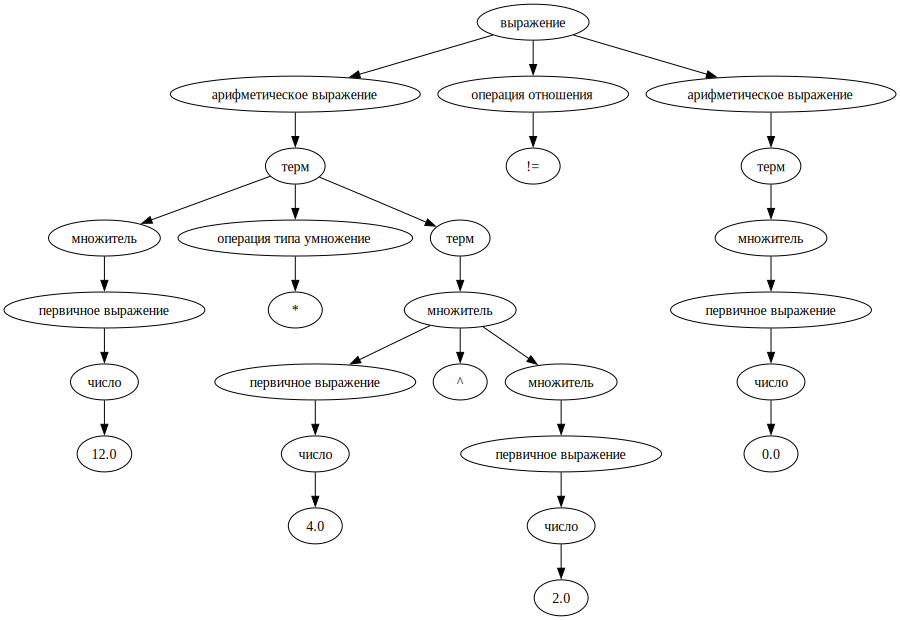

In [73]:
code = "12 * 4 ^ 2 != 0"
print(lexical_analyzer(code))
tree = parse_expr(lexical_analyzer(code), 0)
tree.recurse()

In [65]:
report = run_tests(
    lexical_analyzer,
    [("1 > 2", ["1", ">", "2"],),
	  ("(1 + 1) > 2", ["(", "1", "+", "1", ")", ">", "2"],),
	("(1 * a - 4 ^ 2) > 2", ["(", "1", "*", "a", "-", "4", "^", "2", ")", ">", "2"],),
        ("x^2 - x +1 > e^(x^2)", ["x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")"],),
        ("{ a = 1 > 2; b = x^2 - x +1 > e^(x^2); }", ["{", "a", "=", "1", ">", "2", ";", "b", "=", "x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")", ";", "}"],
        ),
    ],
    True,
)


IPython.display.Markdown(report)

<table><thead><tr><td><div style='width:200px'>Input</div></td><td><div style='width:200px'>Expected Output</div></td><td><div style='width:200px'>Actual Output</div></td><td>Comment</td></tr></thead><tbody><tr><td>

'1 > 2'
</td><td>

['1', '>', '2']
</td><td>

['1', '>', '2']</td><td>

OK
</td></tr>
<tr><td>

'(1 + 1) > 2'
</td><td>

['(', '1', '+', '1', ')', '>', '2']
</td><td>

['(', '1', '+', '1', ')', '>', '2']</td><td>

OK
</td></tr>
<tr><td>

'(1 * a - 4 ^ 2) > 2'
</td><td>

['(', '1', '*', 'a', '-', '4', '^', '2', ')', '>', '2']
</td><td>

['(', '1', '*', 'a', '-', '4', '^', '2', ')', '>', '2']</td><td>

OK
</td></tr>
<tr><td>

'x^2 - x +1 > e^(x^2)'
</td><td>

['x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')']
</td><td>

['x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')']</td><td>

OK
</td></tr>
<tr><td>

'{ a = 1 > 2; b = x^2 - x +1 > e^(x^2); }'
</td><td>

['{', 'a', '=', '1', '>', '2', ';', 'b', '=', 'x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')', ';', '}']
</td><td>

['{', 'a', '=', '1', '>', '2', ';', 'b', '=', 'x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')', ';', '}']</td><td>

OK
</td></tr>
</tbody></table>

Вариант в стиле Си.

```
<программа> ->
    <блок>

<блок> ->
    { <список операторов> }

<список  операторов> ->
    <оператор> <хвост>

<хвост> ->
    ; <оператор> <хвост>  |  \eps
```
 ====


Преобразованный вариант в стиле Си.

```
<программа> ->
    <блок>

<блок> ->
    "{" <список операторов> "}"

<список  операторов> ->
    <оператор> { ";"  <оператор> } ";"

<оператор> ->
    <идентификатор>  = <выражение>

```

In [66]:
def parse_operator(lexems: list[str], startPos: int) -> TreeNode | None:
    tree = make_combine([parse_id, make_parse_lexem("="), parse_expr])(lexems, startPos)
    if not tree:
        return None

    tree.data = "<оператор>"

    return tree


def parse_operator_list(lexems: list[str], startPos: int) -> TreeNode | None:
    tree = make_combine(
        [
            parse_operator,
            make_loop(
                make_combine(
                    [
                        make_parse_lexem(";"),
                        parse_operator,
                    ]
                )
            ),
            make_parse_lexem(";"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<список  операторов>"

    return tree


def parse_block(lexems: list[str], startPos: int) -> TreeNode | None:
    tree = make_combine(
        [
            make_parse_lexem("{"),
            parse_operator_list,
            make_parse_lexem("}"),
        ]
    )(lexems, startPos)
    if not tree:
        return None

    tree.data = "<блок>"

    return tree


def parse_program(lexems: list[str], startPos: int) -> TreeNode | None:
    tree = TreeNode("<выражение>")

    node = parse_block(lexems, startPos)
    if not node:
        return None

    tree.add_child(node)

    return tree


In [67]:
code = """
{
    one = (4 + (6 ^ 11)) > 10;
    two = (0.5 ^ 11 + 13 ^ 0.5) != 1;
}
"""

print(lexical_analyzer(code))
tree = parse_program(lexical_analyzer(code), 0)
tree.recurse().render('parse_tree', format='png', cleanup=True)

['{', 'one', '=', '(', '4', '+', '(', '6', '^', '11', ')', ')', '>', '10', ';', 'two', '=', '(', '0.5', '^', '11', '+', '13', '^', '0.5', ')', '!=', '1', ';', '}']


'parse_tree.png'

In [70]:
report = run_tests(
    lambda x: parse_program(x, 0),
    [
        (["1"], None,),
        (["1", "!=", "2"], None,),
        (["{", "1", "=", "2", ">", "3", ";", "}"], None,),
        (["{", "a", "=", "2", ">", "3", ";", "}"], {},),
        (["{", "b", "=", "x", "^", "2", "-", "x", "+", "1", ">", "e", "^", "(", "x", "^", "2", ")", ";", "}"], {},
        ),
    ],
    True,
    lambda a, b: a is not None or repr(a) == repr(b),
)


IPython.display.Markdown(report)

<table><thead><tr><td><div style='width:200px'>Input</div></td><td><div style='width:200px'>Expected Output</div></td><td><div style='width:200px'>Actual Output</div></td><td>Comment</td></tr></thead><tbody><tr><td>

['1']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['1', '!=', '2']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['{', '1', '=', '2', '>', '3', ';', '}']
</td><td>

None
</td><td>

None</td><td>

OK
</td></tr>
<tr><td>

['{', 'a', '=', '2', '>', '3', ';', '}']
</td><td>

{}
</td><td>

<__main__.TreeNode object at 0x7f87e1e853a0></td><td>

OK
</td></tr>
<tr><td>

['{', 'b', '=', 'x', '^', '2', '-', 'x', '+', '1', '>', 'e', '^', '(', 'x', '^', '2', ')', ';', '}']
</td><td>

{}
</td><td>

<__main__.TreeNode object at 0x7f87e1e85610></td><td>

OK
</td></tr>
</tbody></table>